In [41]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [42]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [43]:
# We filter the country, the variable to predict and the dates

country = 'Spain'
variable = 'new_cases_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [44]:
# We read the endogenous data (coronavirus data) (for now, from a local file)

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])

In [45]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [46]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(242, 1) (242, 14)


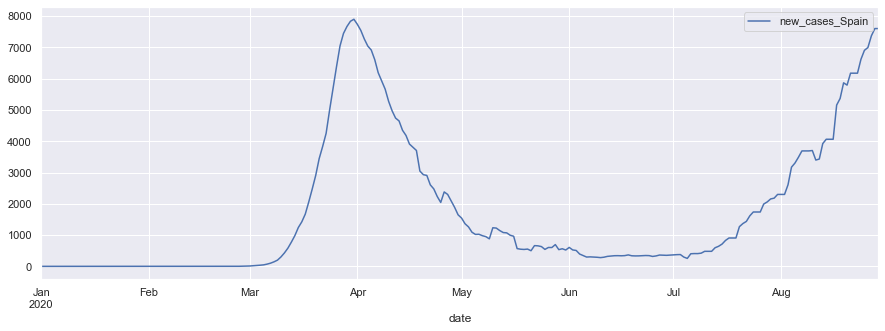

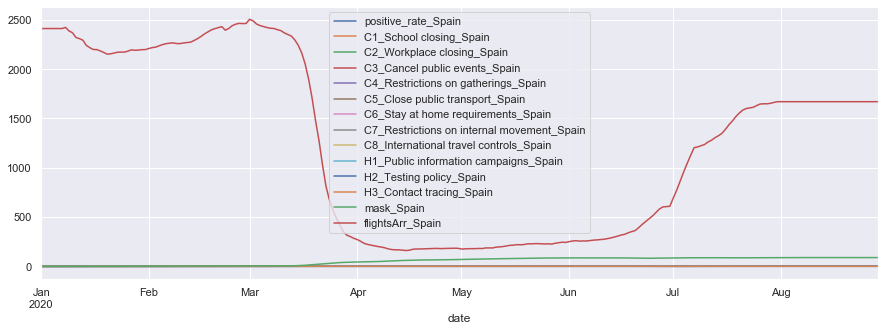

In [47]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [48]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [49]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(242,) (242, 14)


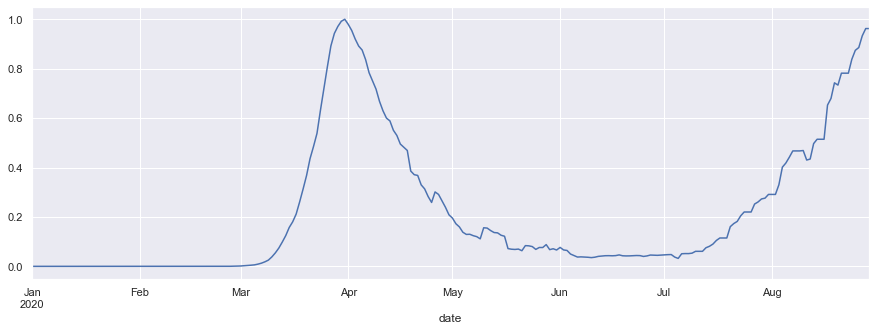

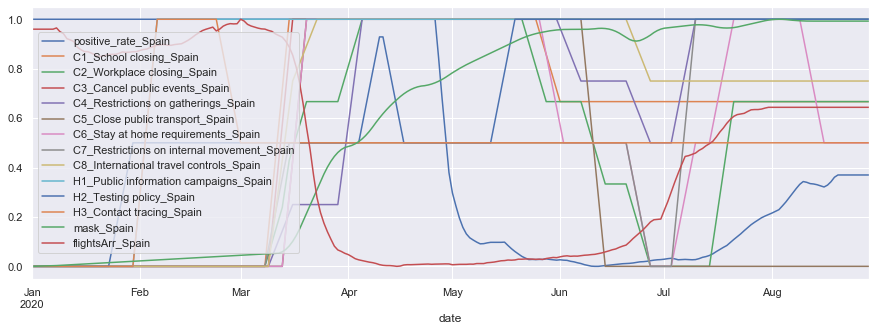

In [50]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [51]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [52]:
train_size, test_size

(205, 37)

# Stationarity: estimate differencing term (d)

In [53]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


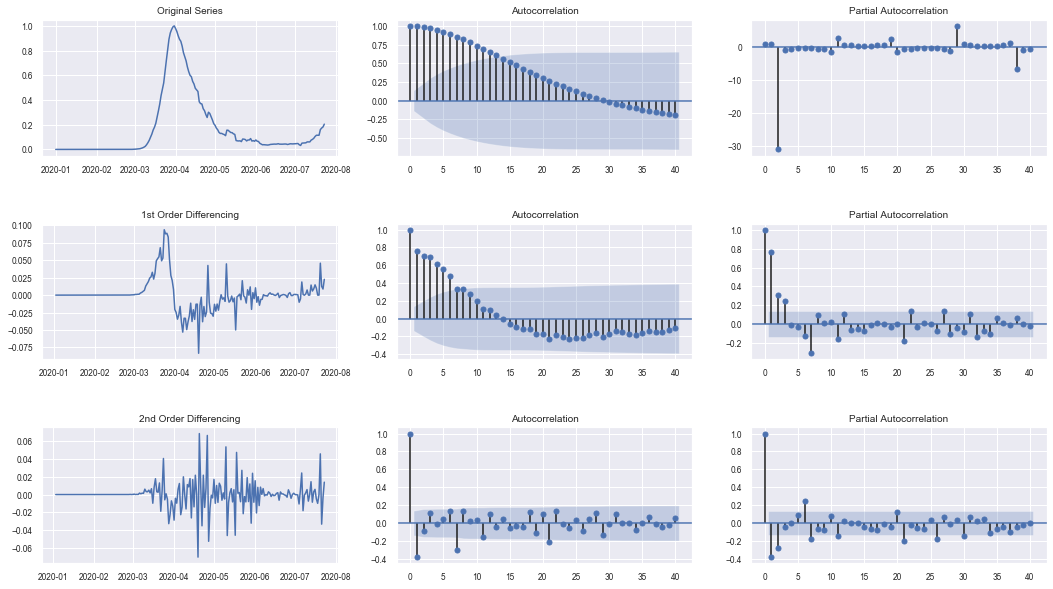

In [54]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

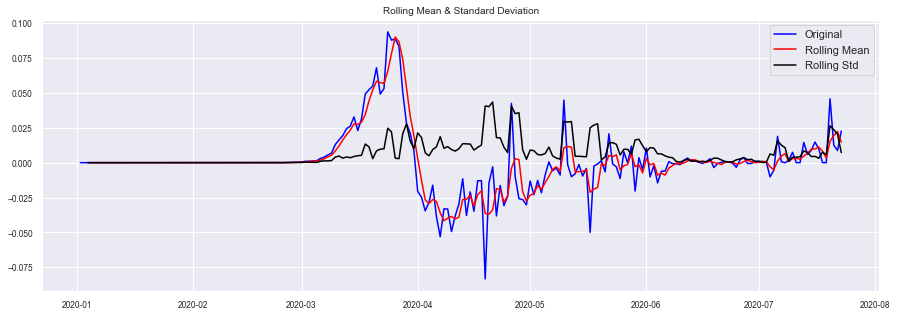

Result of Dicky-Fuller Test


Test Statistic           -3.306939
p-value                   0.014571
#Lags Used                7.000000
#Observations Used      196.000000
Critical Value (1%)      -3.464161
Critical Value (5%)      -2.876402
Critical Value (10%)     -2.574692
dtype: float64

In [55]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [56]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 2, 3)",-1165.670280
1,"(1, 1, 3)",-1157.941519
2,"(1, 1, 3)",-1157.941519
3,"(0, 2, 1)",-1156.286389


# Perform cross-validation on top 2 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [57]:
# Extract top 3 models from previous step (first 3 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])
model3 = ARIMA(order=result_table.iloc[2,0])

In [58]:
best_order = cross_val(y_train, X_train, model1, model2, model3)

Model 1 CV scores: ['0.2335', '0.5056', '0.3555', '535242015979.1756', '3874855429001.8799', '0.3393', '0.0763', '0.0808', '0.2033']
Model 2 CV scores: ['0.0942', '0.3381', '0.0340', '0.0527', '0.0178', '0.0135', '0.0153', '0.0466', '0.6840']
Model 3 CV scores: ['0.0942', '0.3381', '0.0340', '0.0527', '0.0178', '0.0135', '0.0153', '0.0466', '0.6840']
Lowest average MAE: 0.14402197624718646 (model2)
Best model order: (1, 1, 3)


                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  205
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 595.172
Date:                Sun, 30 Aug 2020   AIC                          -1158.344
Time:                        18:47:12   BIC                          -1105.333
Sample:                    01-01-2020   HQIC                         -1136.898
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1990      0.069      2.899      0.004       0.064       0.334
C1_School closing_Spain            

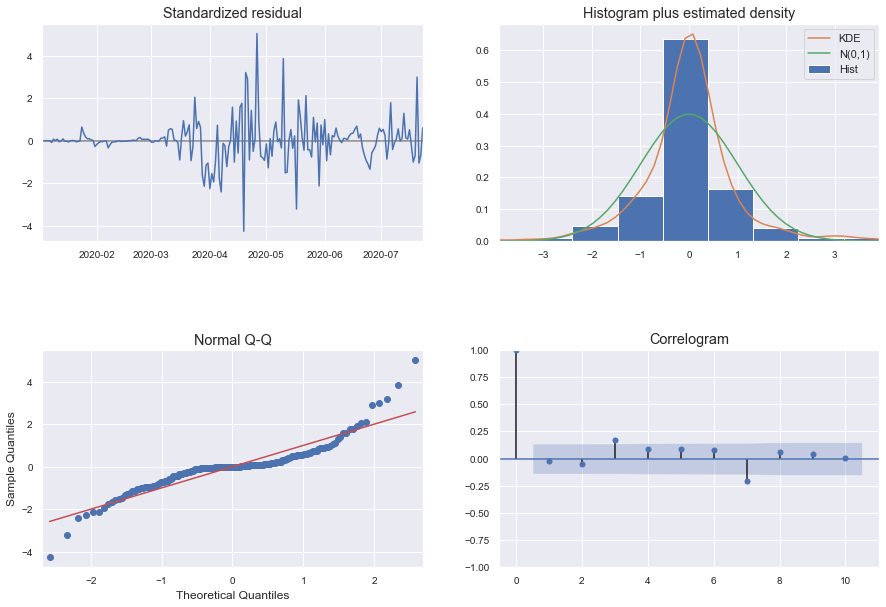

In [81]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=(0,2,1), exog=X_train)
results = best_model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [82]:
train_size, test_size, X_test.shape

(205, 37, (37, 14))

Test MAE: 0.091


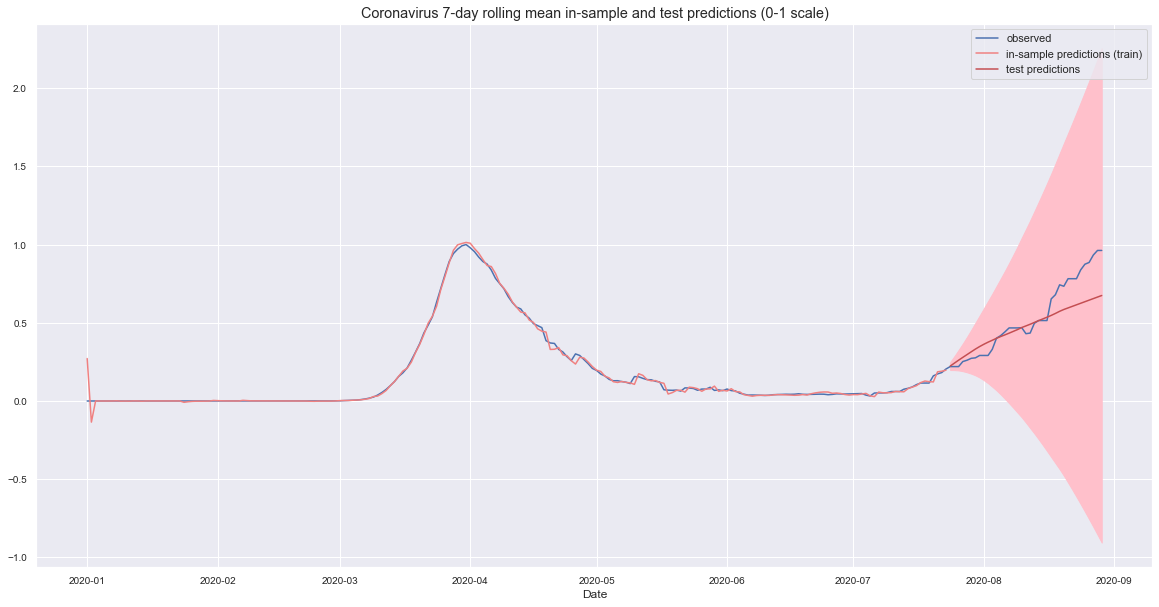

In [83]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [84]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [85]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])

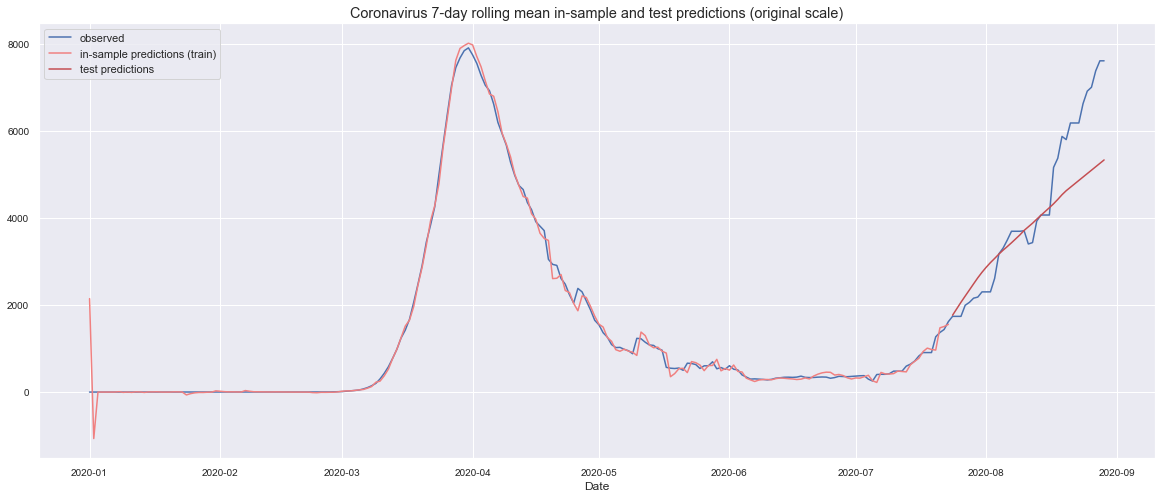

In [86]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [87]:
print("Test MAE (original scale): %.3f" % np.sqrt(mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)))

Test MAE (original scale): 26.813


# Save model so we can then update with future values

In [88]:
# Set model name
filename = './models/' + country + 'SARIMAXmodel.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/SpainSARIMAXmodel.pkl']

In [89]:
# Load the model back in
loaded_model = joblib.load(filename)

In [90]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        new_cases_Spain   No. Observations:                  205
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 595.172
Date:                Sun, 30 Aug 2020   AIC                          -1158.344
Time:                        18:47:14   BIC                          -1105.333
Sample:                    01-01-2020   HQIC                         -1136.898
                         - 07-23-2020                                         
Covariance Type:                  opg                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1990      0.069      2.899      0.004       0.064       0.334
C1_School closing_Spain                       -0.0022      0.097     -0.023      0.982      -0.192       0.188
C2_Workplace closing_Spain                     0.0604      0.076      0.795      0.427      -0.088       0.209
C3_Cancel public events_Spain                  0.2022      0.242      0.837      0.402      -0.271       0.676
C4_Restrictions on gatherings_Spain           -0.0345      0.067     -0.517      0.605      -0.165       0.096
C5_Close public transport_Spain               -0.0317      0.127     -0.250      0.802      -0.280       0.216
C6_Stay at home requirements_Spain            -0.0284      0.113     -0.252      0.801      -0.250       0.193
C7_Restrictions on internal movement_Spain     0.0528      0.098      0.538      0.591      -0.139       0.245
C8_International travel controls_Spain        -0.2785      0.297     -0.937      0.349      -0.861       0.304
H1_Public information campaigns_Spain         -0.0702      1.078     -0.065      0.948      -2.182       2.042
H2_Testing policy_Spain                       -0.1153      0.055     -2.091      0.037      -0.223      -0.007
H3_Contact tracing_Spain                       0.0390      1.059      0.037      0.971      -2.037       2.115
mask_Spain                                     1.8785      0.426      4.409      0.000       1.044       2.714
flightsArr_Spain                               0.0755      0.241      0.314      0.754      -0.396       0.547
ma.L1                                         -0.5501      0.043    -12.777      0.000      -0.634      -0.466
sigma2                                         0.0002   8.82e-06     18.804      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       74.01   Jarque-Bera (JB):               320.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.27   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Update model with test observations, to get it ready for future forecasts

In [91]:
# Update model with test sample and re-fit parameters:
res_updated = results.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  242
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 627.094
Date:                Sun, 30 Aug 2020   AIC                          -1222.188
Time:                        18:47:15   BIC                          -1166.498
Sample:                    01-01-2020   HQIC                         -1199.749
                         - 08-29-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1906      0.090      2.110      0.035       0.014       0.368
C1_School closing_Spain            

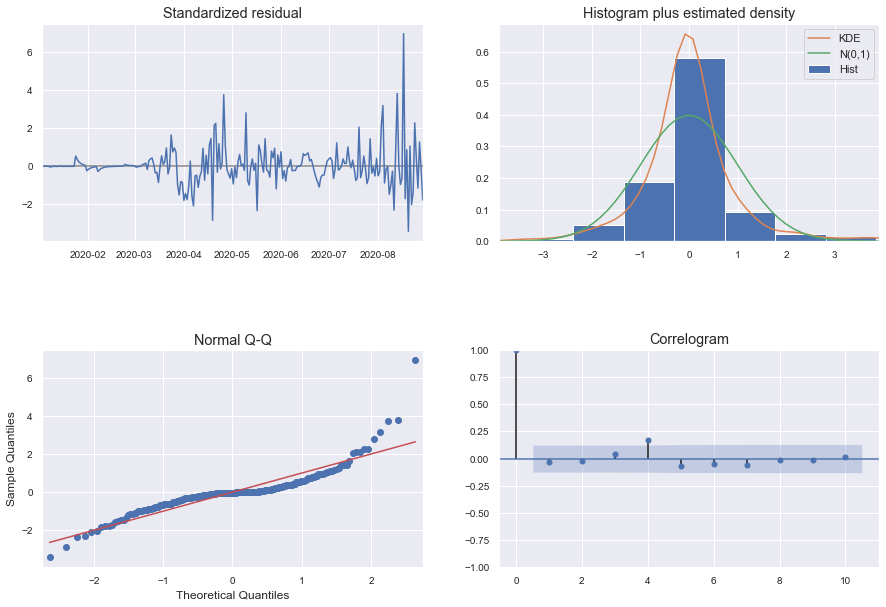

In [92]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

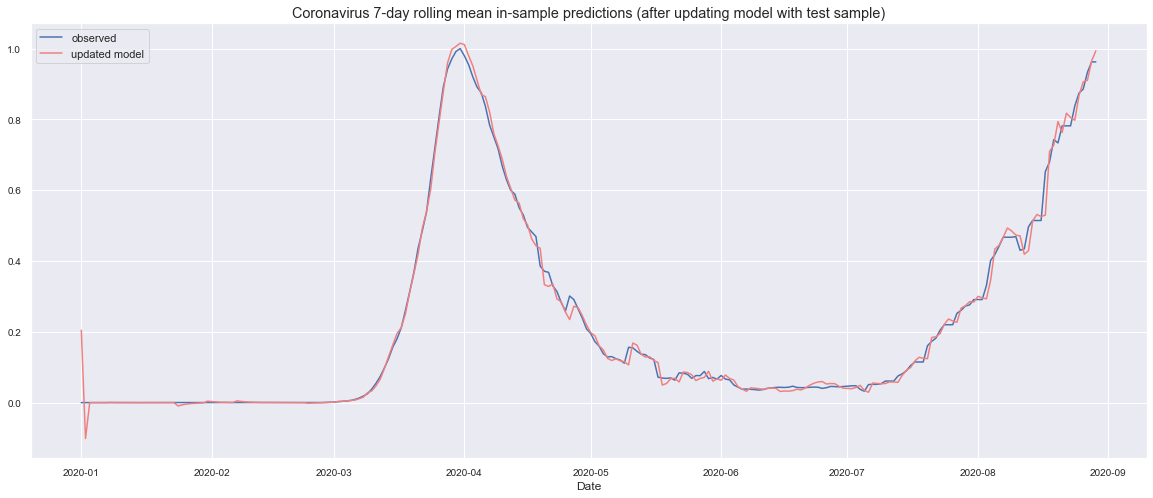

In [93]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [94]:
# Save model again, after updating it with test sample:

joblib.dump(res_updated, filename)

['./models/SpainSARIMAXmodel.pkl']

# Perform forecast

In [95]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdateshift, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

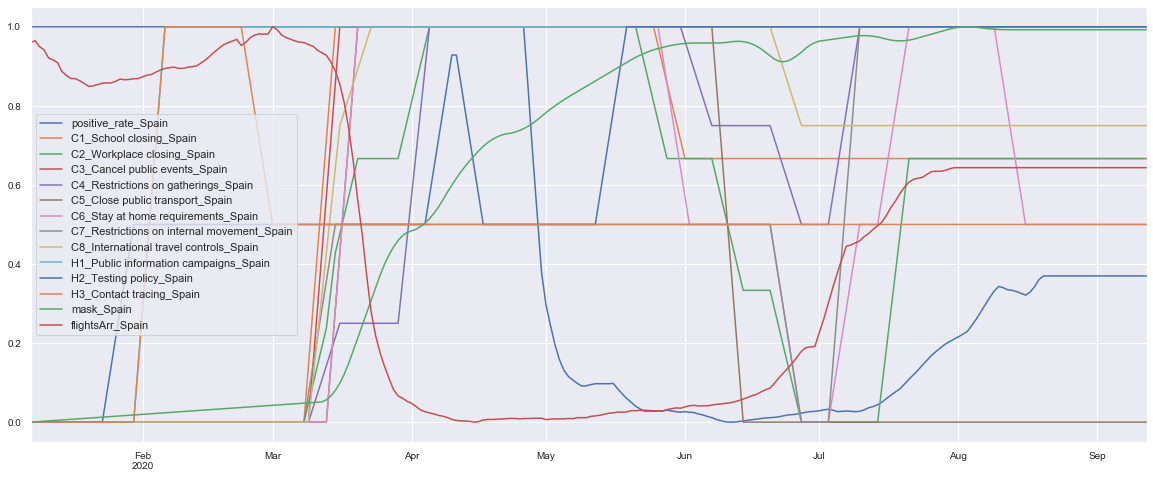

In [96]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.9833204  1.00431309 1.02530578 1.04629846 1.06729115 1.08828383
 1.10927652 1.13026921 1.15126189 1.17225458 1.19324727 1.21423995
 1.23523264 1.25622533]


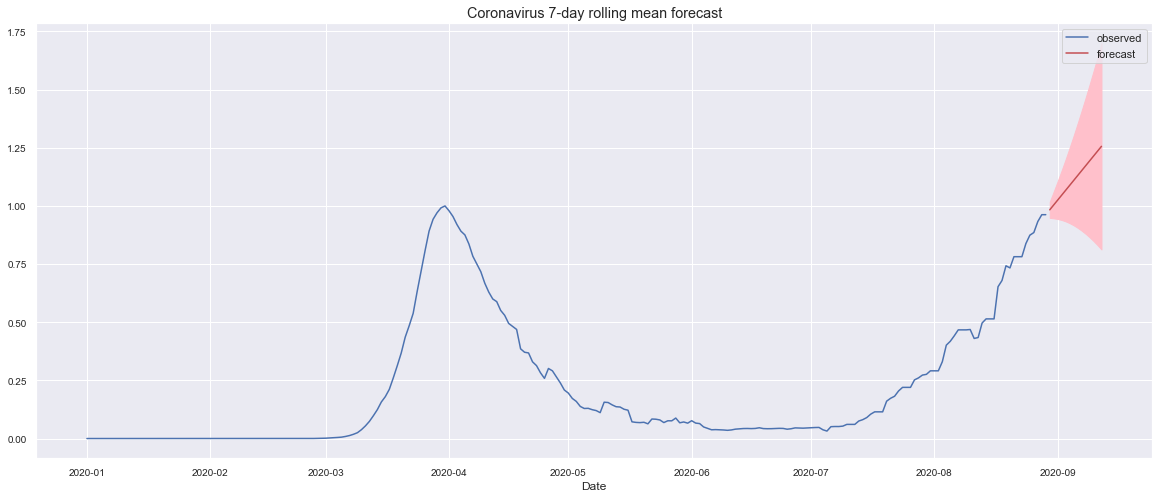

In [97]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [98]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

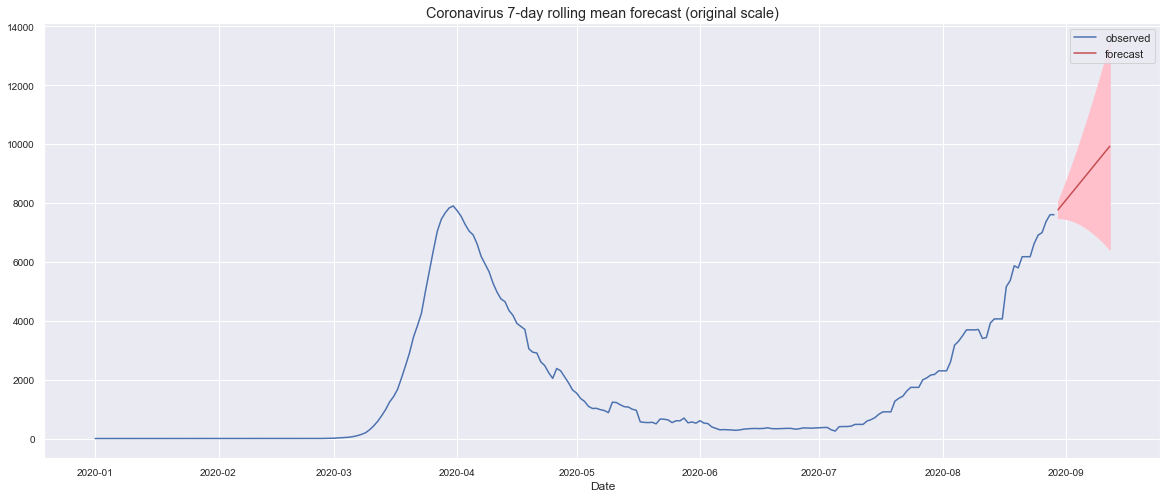

In [99]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.legend()
plt.show()

In [100]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['7770.2', '7936.1', '8102.0', '8267.9', '8433.7', '8599.6', '8765.5', '8931.4', '9097.3', '9263.2', '9429.0', '9594.9', '9760.8', '9926.7']


In [101]:
sm.__version__

'0.11.1'

In [102]:
import pmdarima as pm
pm.__version__

'1.6.1'